In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
pd.set_option('precision', 0)

''' Construct the universal Results-Cyto- data file path in local drive named path
    Enter the row and a list of column indice you want to extract data 
    (e.g row E, column indice = [8, 9, 10])
    Construct a list of well IDs: B02-B10 named WELLS
    Construct a list of field IDs: fld1-fld9 named FIELD
'''
path = './032018_48hrs/Results-Cyto-'

WELLS, rows, cols = [], ['B', 'C', 'D', 'E'], range(2, 11)

for r in rows:
    for k in cols:
        if k < 10:
            WELLS.append(r + '0{}'.format(k))
        else:
            WELLS.append(r + '10')
    
FIELD = ['fld{}'.format(k) for k in range(1, 10)]

files = [path + '{}{}.txt'.format(w, f) 
         for w in WELLS for f in FIELD]

''' Read all Cyto data files in the dataset into a list of dataframes
'''

df_48hrs = [pd.read_csv(file, sep='\t', 
                        engine='python', 
                        usecols=['Label']) for file in files]


''' Double check WELLS, FIELDs that have been processed
    Double check the number of files in the dataset that have been read
'''
n = len(df_48hrs)
print(WELLS)
print(FIELD)
print('Number of files that have been read: ', n)

['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'D02', 'D03', 'D04', 'D05', 'D06', 'D07', 'D08', 'D09', 'D10', 'E02', 'E03', 'E04', 'E05', 'E06', 'E07', 'E08', 'E09', 'E10']
['fld1', 'fld2', 'fld3', 'fld4', 'fld5', 'fld6', 'fld7', 'fld8', 'fld9']
Number of files that have been read:  324


In [2]:
def process(df_list, plate):
    well = r'[A-Z]+.*?(?=_)'
    field = r'(?<=d)[\d]{1,1}?(?=:)'
    cell_id = r'(\d+)-(\d+)'

    for k in range(len(df_list)):
        df_list[k]['Well'] = df_list[k]['Label'].\
                        apply(lambda x: re.search(well, x).group())
        
        df_list[k]['Field'] = df_list[k]['Label'].\
                        apply(lambda x: re.search(field, x).group())
        
        df_list[k]['Cell ID'] = df_list[k]['Label'].\
                        apply(lambda x: re.search(cell_id, x).group())
        
        df_list[k]['Plate'] = plate
        df_list[k] = df_list[k][['Cell ID', 'Well', 'Field', 'Plate']]
    
    return df_list

In [3]:
process(df_48hrs, 2)
;

''

In [4]:
def extract(df_list):
    C = []
    for df in df_list:
        C.append([df.Well[0], 
                 int(df.Field[0]),
                 df.Plate[0],
                 int(df.shape[0] / df['Cell ID'].value_counts()[0])])

    df = pd.DataFrame(C, columns=['Well', 'Field', 'Plate', 'Total Cells'])
    df['Row'] = df['Well'].apply(lambda w: w[0])
    df['Col'] = df['Well'].apply(lambda w: 10 if w[-1] == '0' else int(w[-1]))
    df['Group'] = df['Col'].apply(lambda c: (c - 2)//3)
    df = df[['Well', 'Row', 'Col', 'Field', 'Group', 'Plate','Total Cells']]
    
    return df;

In [5]:
df = extract(df_48hrs)

In [6]:
df

,Well,Row,Col,Field,Group,Plate,Total Cells
0,B02,B,2,1,0,2,545
1,B02,B,2,2,0,2,311
2,B02,B,2,3,0,2,409
3,B02,B,2,4,0,2,568
4,B02,B,2,5,0,2,306
...,...,...,...,...,...,...,...
319,E10,E,10,5,2,2,1096
320,E10,E,10,6,2,2,1206
321,E10,E,10,7,2,2,1213
322,E10,E,10,8,2,2,1159


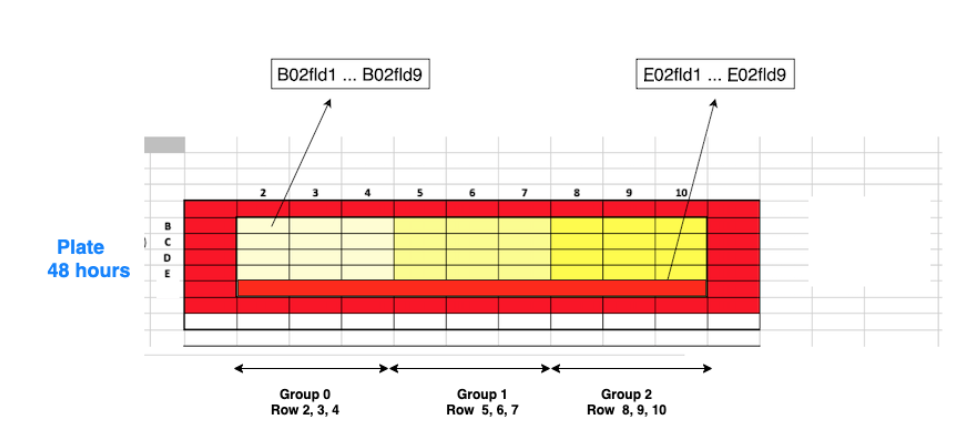

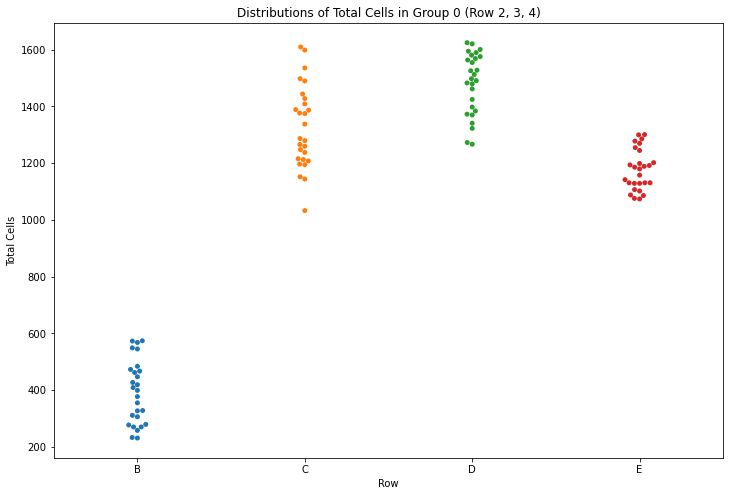

In [7]:
fig = plt.gcf()
fig.set_size_inches(12, 8)
ax = sns.swarmplot(x='Row', y='Total Cells', data=df[df.Group == 0])
ax.set_title('Distributions of Total Cells in Group 0 (Row 2, 3, 4)')
plt.show()

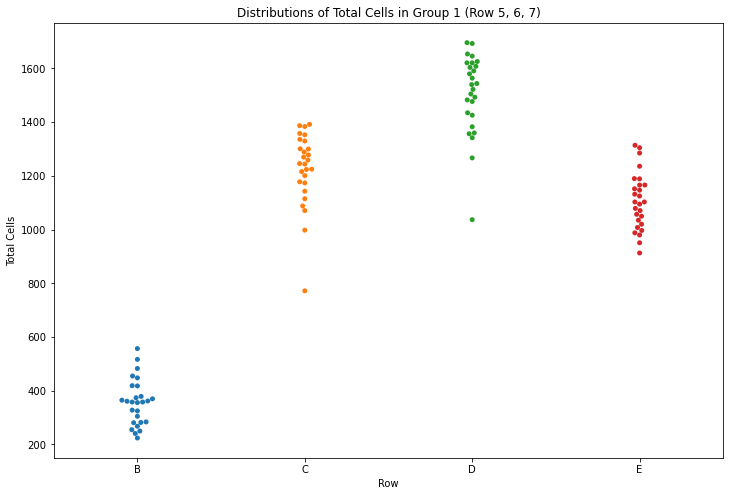

In [8]:
fig = plt.gcf()
fig.set_size_inches(12, 8)
ax = sns.swarmplot(x='Row', y='Total Cells', data=df[df.Group == 1])
ax.set_title('Distributions of Total Cells in Group 1 (Row 5, 6, 7)')
plt.show()

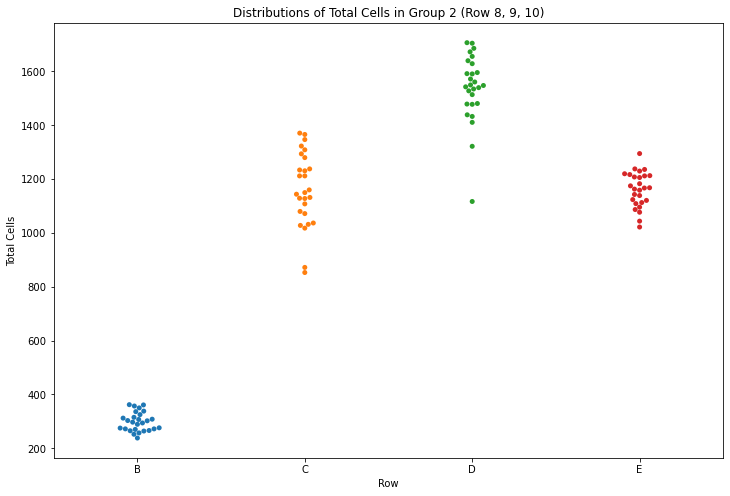

In [9]:
fig = plt.gcf()
fig.set_size_inches(12, 8)
ax = sns.swarmplot(x='Row', y='Total Cells', data=df[df.Group == 2])
ax.set_title('Distributions of Total Cells in Group 2 (Row 8, 9, 10)')
plt.show()

In [10]:
agg = df['Total Cells'].groupby(by=[df['Row'], 
                                    df['Group']]).\
                        agg(['min', 'mean', 'median', 'max', 'std', 'sum'])

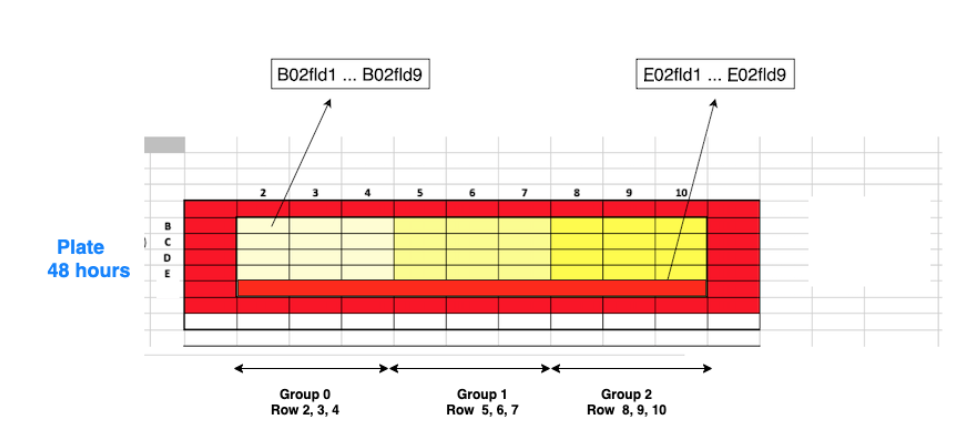

In [11]:
agg

min  mean  median   max  std    sum
Row Group                                      
B   0       231   393     399   574  112  10618
    1       224   356     358   557   86   9623
    2       238   299     297   362   35   8063
C   0      1033  1327    1287  1610  145  35817
    1       772  1227    1246  1392  136  33132
    2       853  1161    1150  1371  137  31360
D   0      1267  1482    1498  1625  108  40012
    1      1037  1506    1540  1696  148  40675
    2      1117  1538    1548  1707  126  41526
E   0      1074  1176    1180  1301   72  31761
    1       913  1106    1103  1314  106  29857
    2      1022  1162    1167  1295   65  31365

In [12]:
def plot_sum(dt, row):
    sns.set(rc={'figure.figsize':(6,6)})
    sns.barplot(x='Group', y='sum', data=dt[dt.Row == row])
    plt.title('Total Cells in Each Group of Row {}'.format(row))
    plt.show()

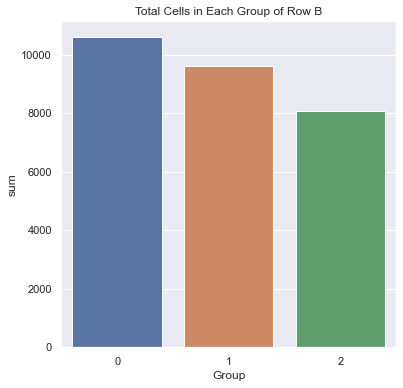

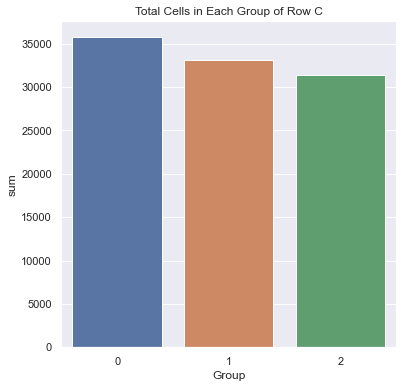

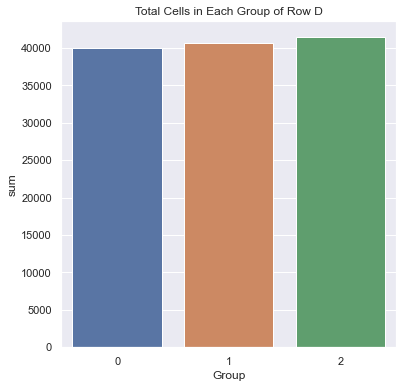

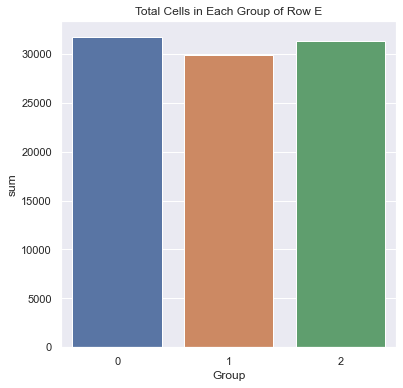

In [13]:
dt = agg.reset_index(level=['Group', 'Row'])
for row in rows:
    plot_sum(dt, row)